In [74]:
import functools
from ema_workbench import Scenario
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import pairs_plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking

from ema_workbench.analysis import feature_scoring
from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from sklearn import preprocessing
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated)

from ema_workbench import ScalarOutcome
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates


In [52]:
# lees de CSV in met de gevonden policies vanuit de MORDM
policies_df = pd.read_csv("candidate_policies.csv")

# zet elke rij om in een Policy-object
candidate_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_df.iterrows()

    ]

In [53]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)
    scenarios=10
    policies=candidate_policies
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=policies )

        experiments, outcomes = results

INFO | pool started with 7 workers
INFO | performing 10 scenarios * 27 policies * 1 model(s) = 270 experiments

100%|████████████████████████████████████████| 270/270 [00:12<00:00, 21.33it/s]
INFO | experiments finished
INFO | terminating pool


In [54]:
results_per_policy = {}


In [55]:
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_sys, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
cost_total = outcomes["A.2 Total Costs"] # (N,)
cost_q75 = np.percentile(cost_total, 75)
target_cost = cost_total >= cost_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_cost

In [56]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,3,82.461358,1.5,0.970719,186.619329,1.0,0.535694,63.353671,1.5,0.275202,...,0,7,3,3,4,5,7,1034,cand_0,dikesnet
1,123,261.124801,1.0,0.610202,265.047019,10.0,0.373658,334.758691,10.0,0.635835,...,0,7,3,3,4,5,7,1035,cand_0,dikesnet
2,90,310.880150,10.0,0.727669,337.003485,1.0,0.884188,140.800573,1.0,0.369025,...,0,7,3,3,4,5,7,1036,cand_0,dikesnet
3,71,188.552791,1.5,0.415151,48.273699,1.0,0.201429,260.049882,1.0,0.905426,...,0,7,3,3,4,5,7,1037,cand_0,dikesnet
4,104,138.859814,1.5,0.867054,124.718311,1.5,0.170319,109.920317,1.5,0.440599,...,0,7,3,3,4,5,7,1038,cand_0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,45,319.697523,10.0,0.571581,84.668602,10.0,0.994997,160.041633,1.5,0.547796,...,2,0,1,3,6,4,5,1039,cand_26,dikesnet
266,26,54.970537,10.0,0.274580,197.174803,1.5,0.406661,34.621101,10.0,0.053323,...,2,0,1,3,6,4,5,1040,cand_26,dikesnet
267,114,226.176124,1.0,0.339177,295.250079,1.5,0.688125,298.390109,1.0,0.832140,...,2,0,1,3,6,4,5,1041,cand_26,dikesnet
268,54,103.710534,1.0,0.045133,223.656234,1.5,0.013892,229.726602,10.0,0.114896,...,2,0,1,3,6,4,5,1042,cand_26,dikesnet


In [67]:
for pol in policies:

    pol_name = pol.name

    # selecteer alleen de runs met exact die naam
    mask_pol = experiments["policy"] == pol_name
    X_pol   = experiments.loc[mask_pol, [u.name for u in model.uncertainties]]
    y_pol   = y[mask_pol]

    # 3) sanity‐checks
    # 3) sanity‐checks
    print(f"Policy {pol.name!r}: {len(X_pol)} runs (y=True: {y_pol.sum()}, y=False: {len(y_pol)-y_pol.sum()})")

    if len(X_pol) == 0:
        print("  → geen runs met deze policy, overslaan")
        continue

    if not (y_pol.dtype == bool):
        y_pol = y_pol.astype(bool)

    if y_pol.sum() == 0 or y_pol.sum() == len(y_pol):
        print("  → y bevat niet zowel True als False, overslaan")
        continue

    # 2) maak en run PRIM
    prim_alg = prim.Prim(
        X_pol,
        y_pol,
        threshold=0.6,       # kies zelf je cover‐of‐density cut‐off
        peel_alpha=0.05,     # hoe “agressief” peel je
        mass_min=0.1        # minimale fractie runs in box
    )
    box = prim_alg.find_box()

    box.inspect()
    #box.show_tradeoff()

    traj = box.peeling_trajectory


    # 3) bewaar je result voor latere vergelijking
    results_per_policy[pol_name] = {
        "prim_alg":   prim_alg,
        "selected_box": box,
        "trajectory":   traj,
        # "box_id": int(traj.score.idxmax())
    }
    #
    # 4) (optioneel) toon trade‐off en inspect en pairplot
    #print(f"\n=== Policy {pol} ===")
    #box.inspect(style="graph")
    #box.show_pairs_scatter()
    plt.show()

INFO | 10 points remaining, containing 6 cases of interest
INFO | mean: 1.0, mass: 0.6, coverage: 1.0, density: 1.0 restricted_dimensions: 3
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{2.5, 3.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO | 10 points remaining, containing 2 cases of interest
INFO | mean: 1.0, mass: 0.2, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{3.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  

Policy 'cand_0': 10 runs (y=True: 6, y=False: 4)
coverage    1.0
density     1.0
id          3.0
k           6.0
mass        0.6
mean        1.0
n           6.0
res_dim     3.0
Name: 3, dtype: float64

                           box 3                                     
                             min              max  qp value  qp value
A.1_Bmax               54.970537       290.411162       NaN  0.396569
A.2_Bmax               48.273699       280.148549       NaN  0.396569
discount rate 2  {2.5, 3.5, 4.5}  {2.5, 3.5, 4.5}  0.396569       NaN

Policy 'cand_1': 10 runs (y=True: 2, y=False: 8)
coverage    1.0
density     1.0
id          3.0
k           2.0
mass        0.2
mean        1.0
n           2.0
res_dim     2.0
Name: 3, dtype: float64

                      box 3                               
                        min         max  qp value qp value
discount rate 0  {3.5, 4.5}  {3.5, 4.5}  0.111111      NaN
A.1_Brate        {1.5, 1.0}  {1.5, 1.0}  0.160000      NaN

Policy '

INFO | mean: 1.0, mass: 0.2, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{3.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO | 10 points remaining, containing 6 cases of interest
INFO | mean: 1.0, mass: 0.6, coverage: 1.0, density: 1.0 restricted_dimensions: 3
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{2.5, 3.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


coverage    1.0
density     1.0
id          3.0
k           2.0
mass        0.2
mean        1.0
n           2.0
res_dim     2.0
Name: 3, dtype: float64

                      box 3                               
                        min         max  qp value qp value
discount rate 0  {3.5, 4.5}  {3.5, 4.5}  0.111111      NaN
A.1_Brate        {1.5, 1.0}  {1.5, 1.0}  0.160000      NaN

Policy 'cand_4': 10 runs (y=True: 6, y=False: 4)
coverage    1.0
density     1.0
id          3.0
k           6.0
mass        0.6
mean        1.0
n           6.0
res_dim     3.0
Name: 3, dtype: float64

                           box 3                                     
                             min              max  qp value  qp value
A.1_Bmax               54.970537       290.411162       NaN  0.396569
A.2_Bmax               48.273699       280.148549       NaN  0.396569
discount rate 2  {2.5, 3.5, 4.5}  {2.5, 3.5, 4.5}  0.396569       NaN

Policy 'cand_5': 10 runs (y=True: 6, y=False: 4)
coverage

INFO | mean: 1.0, mass: 0.3, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.5, 1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO | 10 points remaining, containing 1 cases of interest
INFO | mean: 1.0, mass: 0.1, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO | 10 

coverage    1.0
density     1.0
id          2.0
k           3.0
mass        0.3
mean        1.0
n           3.0
res_dim     2.0
Name: 2, dtype: float64

                           box 2                                    
                             min              max  qp value qp value
A.1_Brate             {1.5, 1.0}       {1.5, 1.0}  0.078717      NaN
discount rate 0  {2.5, 3.5, 4.5}  {2.5, 3.5, 4.5}  0.125000      NaN

Policy 'cand_9': 10 runs (y=True: 1, y=False: 9)
coverage    1.0
density     1.0
id          3.0
k           1.0
mass        0.1
mean        1.0
n           1.0
res_dim     2.0
Name: 3, dtype: float64

                box 3                               
                  min         max  qp value qp value
A.1_Brate       {1.0}       {1.0}  0.166667      NaN
A.4_Brate  {1.5, 1.0}  {1.5, 1.0}  0.333333      NaN

Policy 'cand_10': 10 runs (y=True: 5, y=False: 5)
coverage    1.0
density     1.0
id          3.0
k           5.0
mass        0.5
mean        1.0
n        

INFO | mean: 1.0, mass: 0.2, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{3.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO | 10 points remaining, containing 2 cases of interest
INFO | mean: 1.0, mass: 0.2, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{3.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO 

coverage    1.0
density     1.0
id          3.0
k           2.0
mass        0.2
mean        1.0
n           2.0
res_dim     2.0
Name: 3, dtype: float64

                      box 3                               
                        min         max  qp value qp value
discount rate 0  {3.5, 4.5}  {3.5, 4.5}  0.111111      NaN
A.1_Brate        {1.5, 1.0}  {1.5, 1.0}  0.160000      NaN

Policy 'cand_14': 10 runs (y=True: 2, y=False: 8)
coverage    1.0
density     1.0
id          3.0
k           2.0
mass        0.2
mean        1.0
n           2.0
res_dim     2.0
Name: 3, dtype: float64

                      box 3                               
                        min         max  qp value qp value
discount rate 0  {3.5, 4.5}  {3.5, 4.5}  0.111111      NaN
A.1_Brate        {1.5, 1.0}  {1.5, 1.0}  0.160000      NaN

Policy 'cand_15': 10 runs (y=True: 5, y=False: 5)
coverage    1.0
density     1.0
id          3.0
k           5.0
mass        0.5
mean        1.0
n           5.0
res_dim 

INFO | mean: 1.0, mass: 0.2, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{3.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO | 10 points remaining, containing 3 cases of interest
INFO | mean: 1.0, mass: 0.3, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.5, 1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO 

coverage    1.0
density     1.0
id          3.0
k           2.0
mass        0.2
mean        1.0
n           2.0
res_dim     2.0
Name: 3, dtype: float64

                      box 3                               
                        min         max  qp value qp value
discount rate 0  {3.5, 4.5}  {3.5, 4.5}  0.111111      NaN
A.1_Brate        {1.5, 1.0}  {1.5, 1.0}  0.160000      NaN

Policy 'cand_19': 10 runs (y=True: 3, y=False: 7)
coverage    1.0
density     1.0
id          2.0
k           3.0
mass        0.3
mean        1.0
n           3.0
res_dim     2.0
Name: 2, dtype: float64

                           box 2                                    
                             min              max  qp value qp value
A.1_Brate             {1.5, 1.0}       {1.5, 1.0}  0.078717      NaN
discount rate 0  {2.5, 3.5, 4.5}  {2.5, 3.5, 4.5}  0.125000      NaN

Policy 'cand_20': 10 runs (y=True: 10, y=False: 0)
  → y bevat niet zowel True als False, overslaan
Policy 'cand_21': 10 runs (y=T

INFO | mean: 1.0, mass: 0.2, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{3.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO | 10 points remaining, containing 3 cases of interest
INFO | mean: 1.0, mass: 0.3, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.5, 1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
INFO 

coverage    1.0
density     1.0
id          3.0
k           2.0
mass        0.2
mean        1.0
n           2.0
res_dim     2.0
Name: 3, dtype: float64

                      box 3                               
                        min         max  qp value qp value
discount rate 0  {3.5, 4.5}  {3.5, 4.5}  0.111111      NaN
A.1_Brate        {1.5, 1.0}  {1.5, 1.0}  0.160000      NaN

Policy 'cand_23': 10 runs (y=True: 3, y=False: 7)
coverage    1.0
density     1.0
id          2.0
k           3.0
mass        0.3
mean        1.0
n           3.0
res_dim     2.0
Name: 2, dtype: float64

                           box 2                                    
                             min              max  qp value qp value
A.1_Brate             {1.5, 1.0}       {1.5, 1.0}  0.078717      NaN
discount rate 0  {2.5, 3.5, 4.5}  {2.5, 3.5, 4.5}  0.125000      NaN

Policy 'cand_24': 10 runs (y=True: 2, y=False: 8)
coverage    1.0
density     1.0
id          3.0
k           2.0
mass        0.2


/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.5, 1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


In [63]:
from pandas.api.types import is_numeric_dtype

# 1) lijst van alle uncertainty-kolommen
cols_unc = [u.name for u in model.uncertainties]

# 2) per kolom zelf min/max bepalen, alleen als 'ie numeriek is
global_ranges = {}
for var in cols_unc:
    ser = experiments[var]
    if is_numeric_dtype(ser):
        lo = ser.min()
        hi = ser.max()
        global_ranges[var] = (lo, hi)
    else:
        # categoricals slaan we over, of bewaar je volledige domain als set:
        cats = ser.cat.categories if hasattr(ser.dtype, "categories") else None
        print(f"  → sla {var!r} over (dtype={ser.dtype})")

# 3) print ter controle
for var, (lo, hi) in global_ranges.items():
    print(f"{var:30s}  glob_min = {lo:8.3f},  glob_max = {hi:8.3f}")

  → sla 'discount rate 0' over (dtype=category)
  → sla 'discount rate 1' over (dtype=category)
  → sla 'discount rate 2' over (dtype=category)
  → sla 'A.1_Brate' over (dtype=category)
  → sla 'A.2_Brate' over (dtype=category)
  → sla 'A.3_Brate' over (dtype=category)
  → sla 'A.4_Brate' over (dtype=category)
  → sla 'A.5_Brate' over (dtype=category)
A.0_ID flood wave shape         glob_min =    3.000,  glob_max =  123.000
A.1_Bmax                        glob_min =   54.971,  glob_max =  319.698
A.1_pfail                       glob_min =    0.045,  glob_max =    0.971
A.2_Bmax                        glob_min =   48.274,  glob_max =  337.003
A.2_pfail                       glob_min =    0.014,  glob_max =    0.995
A.3_Bmax                        glob_min =   34.621,  glob_max =  334.759
A.3_pfail                       glob_min =    0.053,  glob_max =    0.905
A.4_Bmax                        glob_min =   50.088,  glob_max =  334.940
A.4_pfail                       glob_min =    0.044,  

In [64]:
# summary = []
# for pol_name, data in results_per_policy.items():
#     box = data["selected_box"]
#     # 1) pak de raw limits en zet in één DataFrame
#     lims = pd.DataFrame(
#         box.box_lims[0],
#         columns=["var","min","max"]
#     ).set_index("var")
#
#     # 2) filter alleen de dims die wél numeriek in global_ranges staan
#     numeric_vars = [v for v in lims.index if v in global_ranges]
#
#     # 3) volume = product over (hi-lo)/(glob_hi-glob_lo)
#     vol = 1.0
#     for v in numeric_vars:
#         lo, hi = lims.loc[v, ["min","max"]]
#         glob_lo, glob_hi = global_ranges[v]
#         vol *= (hi - lo) / (glob_hi - glob_lo)
#
#     # 4) verzamel je summary
#     summary.append({
#         "policy":   pol_name,
#         "res_dim":  box.res_dim,
#         "coverage": box.coverage,
#         "density":  box.density,
#         "volume":   vol
#     })
#
# df_summary = pd.DataFrame(summary)

In [70]:
# --- 1) bereken overall failure rate per policy ---
# 'y' is je boolean Series met True voor falende runs
overall = (
    experiments
      .groupby("policy")
      .apply(lambda df: y[df.index].mean())
      .rename("overall_fail_rate")
)

# --- 2) verzamel PRIM‐metrics uit de geselecteerde box voor elke policy ---
box_info = []
for pol, info in results_per_policy.items():
    box = info["selected_box"]   # dit is een PrimBox
    box_info.append({
        "policy":   pol,
        "coverage": box.coverage,
        "density":  box.density,
        "res_dim":  box.res_dim,
        "mass":     box.mass
    })

box_df = pd.DataFrame(box_info).set_index("policy")

# --- 3) combineer alles in één rapport-DataFrame ---
report = pd.concat([overall, box_df], axis=1)

# zet de fracties om in percentages
report["overall_fail_%"]       = report.overall_fail_rate * 100
report["box_covers_%"]         = report.coverage        * 100
report["fail_in_box_%"]        = report.density         * 100

# selecteer en sorteer kolommen
report = report[[
    "overall_fail_%",
    "box_covers_%",
    "fail_in_box_%",
    "res_dim",
    "mass"
]].sort_values("overall_fail_%", ascending=False)

# afronden op 1 decimaal
report = report.round(1)

report

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_59979/1113714810.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("policy")


,overall_fail_%,box_covers_%,fail_in_box_%,res_dim,mass
policy,,,,,
cand_20,100.0,NaN,NaN,NaN,NaN
cand_4,60.0,100.0,100.0,3.0,0.6
cand_5,60.0,100.0,100.0,3.0,0.6
cand_0,60.0,100.0,100.0,3.0,0.6
cand_11,60.0,100.0,100.0,3.0,0.6
cand_25,50.0,100.0,100.0,3.0,0.5
cand_15,50.0,100.0,100.0,3.0,0.5
cand_16,50.0,100.0,100.0,3.0,0.5
cand_10,50.0,100.0,100.0,3.0,0.5



Policy cand_0, top 3 drivers van falen:
  • A.2_pfail                 importans=0.210
  • A.5_pfail                 importans=0.147
  • A.1_Bmax                  importans=0.094

Policy cand_1, top 3 drivers van falen:
  • A.2_pfail                 importans=0.195
  • A.4_Bmax                  importans=0.193
  • discount rate 0           importans=0.117

Policy cand_2, top 3 drivers van falen:
  • A.2_pfail                 importans=0.195
  • A.4_Bmax                  importans=0.193
  • discount rate 0           importans=0.117

Policy cand_3, top 3 drivers van falen:
  • A.2_pfail                 importans=0.195
  • A.4_Bmax                  importans=0.193
  • discount rate 0           importans=0.117

Policy cand_4, top 3 drivers van falen:
  • A.2_pfail                 importans=0.210
  • A.5_pfail                 importans=0.147
  • A.1_Bmax                  importans=0.094

Policy cand_5, top 3 drivers van falen:
  • A.2_pfail                 importans=0.210
  • A.5_pfail     

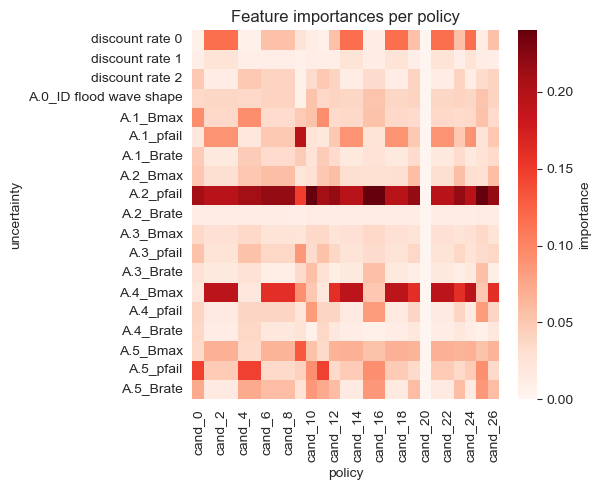

In [71]:
# 2) maak een DataFrame om alle importances te verzamelen
imp_df = pd.DataFrame(index=cols_unc)

# 3) loop over policies
for pol in candidate_policies:
    name = pol.name

    # a) subset X en y voor deze policy
    mask = experiments["policy"] == name
    X_pol = experiments.loc[mask, cols_unc]
    y_pol = y[mask]

    # b) train een random forest
    rf = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0)
    rf.fit(X_pol, y_pol)

    # c) sla de importances op
    fi = pd.Series(rf.feature_importances_, index=cols_unc)
    # zet de top 5 alvast in de tabel
    imp_df[name] = fi

# 4) bekijk per policy de top 3 drivers
for name in imp_df.columns:
    top3 = imp_df[name].sort_values(ascending=False).head(3)
    print(f"\nPolicy {name}, top 3 drivers van falen:")
    for var,score in top3.items():
        print(f"  • {var:25s} importans={score:.3f}")

# 5) (optioneel) heatmap van alle importances
plt.figure(figsize=(6,5))
sns.heatmap(imp_df.fillna(0), cmap="Reds", cbar_kws={"label":"importance"})
plt.title("Feature importances per policy")
plt.xlabel("policy")
plt.ylabel("uncertainty")
plt.tight_layout()
plt.show()

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_59979/2233607478.py:22: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  plt.tight_layout()
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


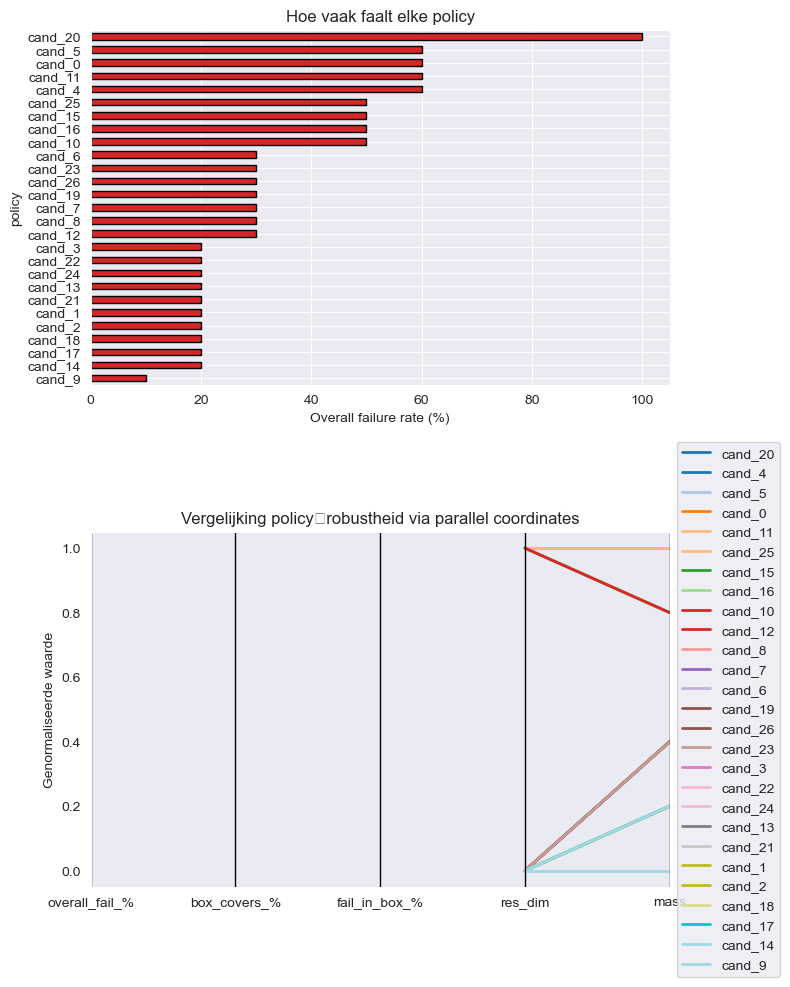

In [75]:
# 1) Bar chart van overall failure
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

report['overall_fail_%']\
    .sort_values(ascending=False)\
    .plot.barh(ax=axes[0], color='C3', edgecolor='k')
axes[0].invert_yaxis()
axes[0].set_xlabel("Overall failure rate (%)")
axes[0].set_title("Hoe vaak faalt elke policy")

# 2) Parallel coordinates voor de PRIM‐metrics
#   we normaliseren eerst alle kolommen naar [0,1] voor gelijke weging

df_norm = (report - report.min()) / (report.max() - report.min())
df_norm['policy'] = df_norm.index

parallel_coordinates(df_norm, 'policy', ax=axes[1], colormap='tab20', linewidth=2)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
axes[1].set_title("Vergelijking policy‐robustheid via parallel coordinates")
axes[1].set_ylabel("Genormaliseerde waarde")

plt.tight_layout()
plt.show()

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_59979/2411788540.py:23: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  plt.tight_layout()
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


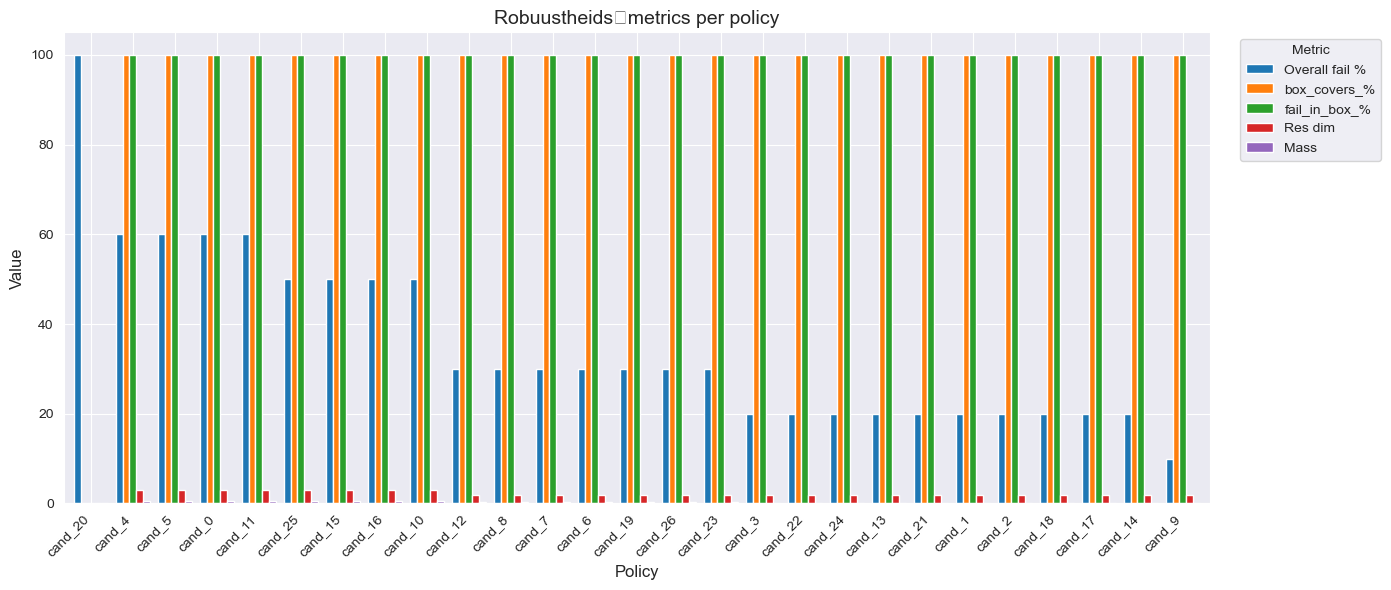

In [77]:
# 1) Maak de kolomnamen korter voor de plot
plot_df = report.rename(columns={
    "overall_fail_%":     "Overall fail %",
    "box_covers_% (coverage)": "Coverage %",
    "fail_in_box_% (density)": "Density %",
    "res_dim":            "Res dim",
    "mass":               "Mass"
})

# 2) Plot als gegroepeerde bar chart
ax = plot_df.plot(
    kind="bar",
    figsize=(14, 6),
    width=0.8
)

# 3) Fijnafstemming
ax.set_xlabel("Policy", fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Robuustheids‐metrics per policy", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_59979/3239923150.py:37: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  plt.tight_layout()
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


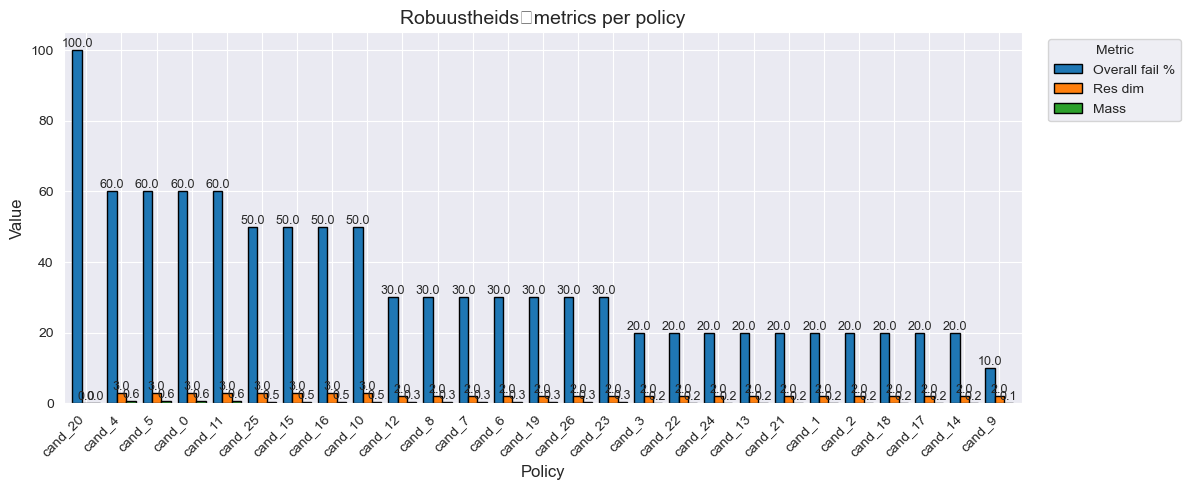

In [78]:

# 1) Selecteer alleen de gewenste kolommen
plot_df = report[[
    "overall_fail_%",  # overall failure rate
    "res_dim",         # restricted dimensions
    "mass"             # mass
]].rename(columns={
    "overall_fail_%": "Overall fail %",
    "res_dim":        "Res dim",
    "mass":           "Mass"
})

# 2) Plot de gegroepeerde staafgrafiek
ax = plot_df.plot(
    kind="bar",
    figsize=(12, 5),
    width=0.8,
    edgecolor="black"
)

# 3) Voeg cijfers boven iedere staaf toe
for p in ax.patches:
    x = p.get_x() + p.get_width()/2    # horizontaal midden van de staaf
    y = p.get_height()                  # hoogte van de staaf
    ax.text(
        x, y,                          # positie
        f"{y:.1f}",                    # tekst (één decimaal)
        ha="center", va="bottom",      # centreren en net boven de staaf
        fontsize=9
    )

# 4) Opmaak
ax.set_xlabel("Policy", fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Robuustheids‐metrics per policy", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()